This version dropped bodyweight, excluded GCS >= 6, re-coded heart rhythm into 4 categories.

Final sample size: 577.\
Output: df_clean_0424_CVICU.csv

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno

In [65]:
# Set global formatting
# Visualize the data for key features 
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

palette = sns.color_palette("Set1")
palette

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

# Load Data

In [66]:
df = pd.read_excel('./data/MIMIC DATA INCLUSION.xlsx', sheet_name='Final Data')
df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,last_gcs_charttime,first_gcs_motor_eyes,first_gcs_charttime,apsiii,oasis
0,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:00,2131-01-20 08:27:00,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,...,2.0,6,2.0,10,6,2131-01-19 20:00:00,2.0,2131-01-11 16:00:00,56,34
1,10024982,25154057,37919901,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2203-09-20 18:27:00,2203-10-11 22:39:00,21.174840,2203-09-19 12:29:00,2203-10-11 19:10:00,...,2.0,7,2.0,2,1,2203-10-11 08:00:00,2.0,2203-09-21 03:30:00,100,45
2,10109956,26022059,37631738,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2184-05-09 14:57:00,2184-05-23 22:23:00,14.309620,2184-05-05 00:00:00,2184-06-04 14:12:00,...,2.0,10,2.0,10,6,2184-05-23 20:00:00,2.0,2184-05-09 23:38:00,86,52
3,10131457,21876540,38790233,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Intermediate,2143-03-21 02:43:00,2143-03-31 16:25:00,10.571080,2143-03-21 01:33:00,2143-03-31 15:00:00,...,2.0,2,2.0,10,6,2143-03-31 14:00:00,9.0,2143-03-21 11:33:00,31,33
4,10144145,29668384,39712677,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2115-01-02 20:41:00,2115-01-17 18:31:00,14.909870,2115-01-02 20:41:00,2115-04-03 04:30:00,...,1.0,5,2.0,9,5,2115-01-17 16:00:00,2.0,2115-01-03 05:51:00,109,33


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 71 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   subject_id                             700 non-null    int64         
 1   hadm_id                                700 non-null    int64         
 2   stay_id                                700 non-null    int64         
 3   first_careunit                         700 non-null    object        
 4   last_careunit                          700 non-null    object        
 5   intime                                 700 non-null    datetime64[ns]
 6   outtime                                700 non-null    datetime64[ns]
 7   los                                    700 non-null    float64       
 8   admittime                              700 non-null    datetime64[ns]
 9   dischtime                              700 non-null    datetime64

In [68]:
print('Total rows=', df.shape[0], ' cols=', df.shape[1])

Total rows= 700  cols= 71


In [69]:
print('Checking id uniquueness, Number of unique items in id')
print(df['subject_id'].nunique())
print(df['hadm_id'].nunique())
print(df['stay_id'].nunique())

Checking id uniquueness, Number of unique items in id
700
700
700


In [70]:
print('number of dead based on hopital_expire_flag:', df['hospital_expire_flag'].sum())
print('number of people with deathtime:', df['deathtime'].notnull().sum())
print('Discrepancy of 3, decided to use based on hopital_expire_flag')

number of dead based on hopital_expire_flag: 358
number of people with deathtime: 355
Discrepancy of 3, decided to use based on hopital_expire_flag


In [71]:
df[(df['hospital_expire_flag']== 1)& (df['deathtime'].isnull())]['discharge_location']

7      DIED
40     DIED
253    DIED
Name: discharge_location, dtype: object

no need to remove rows with no deathtime, assume as dead, likely dead and only missing deathtime

In [72]:
#df[(df['hospital_expire_flag']== 1)& (df['deathtime'].isnull())]
#index_todrop = df[(df['hospital_expire_flag']== 1)& (df['deathtime'].isnull())].index
#df.drop(index_todrop, axis=0, inplace=True)

In [73]:
#print('After dropping rows with incosistent hopital_expire_flag and deathtime : rows=', df.shape[0], ' cols=', df.shape[1]) 

In [74]:
df['first_careunit'].unique()

array(['Medical Intensive Care Unit (MICU)', 'Coronary Care Unit (CCU)',
       'Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'Trauma SICU (TSICU)', 'Surgical Intensive Care Unit (SICU)',
       'Cardiac Vascular Intensive Care Unit (CVICU)'], dtype=object)

In [75]:
df[df['first_careunit'] == 'Cardiac Vascular Intensive Care Unit (CVICU)']['expose'].value_counts()

0    94
1    12
Name: expose, dtype: int64

# Missing Values

In [76]:
#msno.bar(df, labels=True, sort='ascending')

In [77]:
#msno.matrix(df)

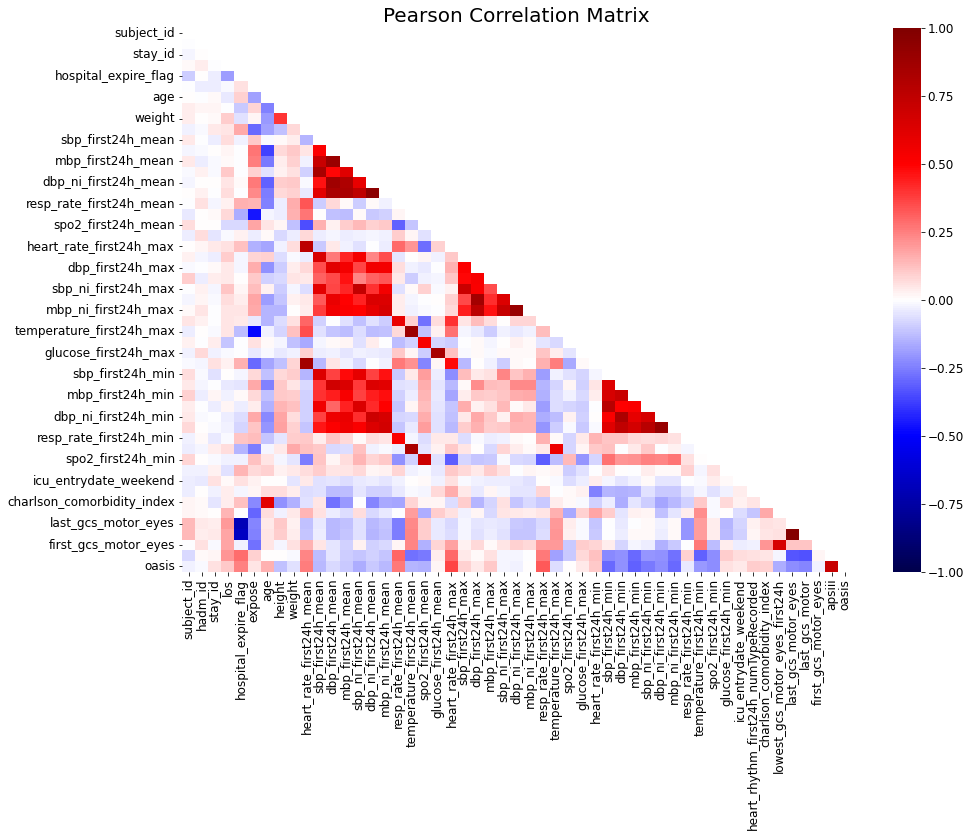

In [78]:
plt.figure(figsize=(15,10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(data= corr_matrix, mask = mask, cmap='seismic', vmax = 1, vmin=-1, annot=False, fmt='0.2f')
plt.title('Pearson Correlation Matrix', fontsize = 20)
plt.show()

### Drop columns due to high missing values:  

    'ethnicity', 'height', 
    'sbp_ni_first24h_mean','dbp_ni_first24h_mean', 'mbp_ni_first24h_mean',
    'sbp_ni_first24h_min', 'dbp_ni_first24h_min','mbp_ni_first24h_min', 
    'sbp_ni_first24h_max', 'dbp_ni_first24h_max','mbp_ni_first24h_max',
    'temperature_first24h_mean', 'temperature_first24h_max', 'temperature_first24h_min'
    
### Drop unused columns  and highly correlated columns

    'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'edregtime',
       'edouttime', 'sbp_first24h_mean', 'dbp_first24h_mean', 'glucose_first24h_mean',
    'heart_rate_first24h_max', 'sbp_first24h_max', 'dbp_first24h_max', 'mbp_first24h_max',
    'resp_rate_first24h_max', 'spo2_first24h_max', 'glucose_first24h_max',
    'heart_rate_first24h_min', 'sbp_first24h_min', 'dbp_first24h_min',
    'mbp_first24h_min', 'resp_rate_first24h_min', 'spo2_first24h_min', 'glucose_first24h_min'

glucose dropped not relevant from lit rev

In [79]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'ethnicity', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'expose', 'age', 'gender',
       'height', 'weight', 'heart_rate_first24h_mean', 'sbp_first24h_mean',
       'dbp_first24h_mean', 'mbp_first24h_mean', 'sbp_ni_first24h_mean',
       'dbp_ni_first24h_mean', 'mbp_ni_first24h_mean',
       'resp_rate_first24h_mean', 'temperature_first24h_mean',
       'spo2_first24h_mean', 'glucose_first24h_mean',
       'heart_rate_first24h_max', 'sbp_first24h_max', 'dbp_first24h_max',
       'mbp_first24h_max', 'sbp_ni_first24h_max', 'dbp_ni_first24h_max',
       'mbp_ni_first24h_max', 'resp_rate_first24h_max',
       'temperature_first24h_max', 'spo2_first24h_max', 'glucose_first24h_max',
       'heart_rate_first24h_

In [80]:
to_drop = ['ethnicity', 'height', 'weight',
    'sbp_ni_first24h_mean','dbp_ni_first24h_mean', 'mbp_ni_first24h_mean',
    'sbp_ni_first24h_min', 'dbp_ni_first24h_min','mbp_ni_first24h_min', 
    'sbp_ni_first24h_max', 'dbp_ni_first24h_max','mbp_ni_first24h_max',
    'temperature_first24h_mean', 'temperature_first24h_max', 'temperature_first24h_min',
    'hadm_id', 'stay_id', 'last_careunit', 
    'intime','outtime', 'admittime', 'dischtime', 'deathtime',
    'admission_type', 'admission_location', 'discharge_location',
    'insurance', 'language', 'marital_status', 'edregtime',
    'edouttime', 'sbp_first24h_mean', 'dbp_first24h_mean', 'glucose_first24h_mean',
    'sbp_first24h_max', 'dbp_first24h_max',
    'glucose_first24h_max',
    'sbp_first24h_min', 'dbp_first24h_min',
    'glucose_first24h_min', 'first_gcs_charttime', 'last_gcs_charttime'
]

df.drop(to_drop, axis=1, inplace=True)
print('Dropping columns: rows=', df.shape[0], ' cols=', df.shape[1]) 

Dropping columns: rows= 700  cols= 29


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             700 non-null    int64  
 1   first_careunit                         700 non-null    object 
 2   los                                    700 non-null    float64
 3   hospital_expire_flag                   700 non-null    int64  
 4   expose                                 700 non-null    int64  
 5   age                                    700 non-null    float64
 6   gender                                 700 non-null    object 
 7   heart_rate_first24h_mean               698 non-null    float64
 8   mbp_first24h_mean                      698 non-null    float64
 9   resp_rate_first24h_mean                698 non-null    float64
 10  spo2_first24h_mean                     696 non-null    float64
 11  heart_

In [82]:
# dep_var = [
#     'expose', 'gender', 'icu_entrydate_weekend', 
#     'heart_rhythm_first24h_firstRecorded','heart_rhythm_first24h_numTypeRecorded',
#     'age','weight',
#     'heart_rate_first24h_mean', 'sbp_first24h_mean','dbp_first24h_mean', 'mbp_first24h_mean',
#     'resp_rate_first24h_mean','spo2_first24h_mean', 'glucose_first24h_mean',
#     'heart_rate_first24h_max', 'sbp_first24h_max', 'dbp_first24h_max','mbp_first24h_max', 
#     'resp_rate_first24h_max', 'spo2_first24h_max', 'glucose_first24h_max',
#     'heart_rate_first24h_min', 'sbp_first24h_min', 'dbp_first24h_min','mbp_first24h_min', 
#     'resp_rate_first24h_min', 'spo2_first24h_min', 'glucose_first24h_min',
#     'charlson_comorbidity_index', lowest_gcs_verbal_eyes_first24h]

# Outcomes

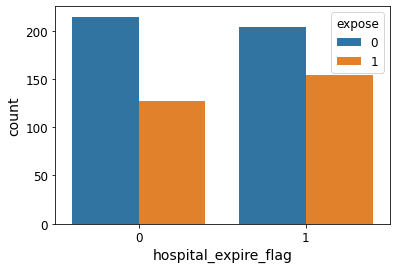

In [83]:
sns.countplot(x = 'hospital_expire_flag', data=df, hue='expose')
plt.show()

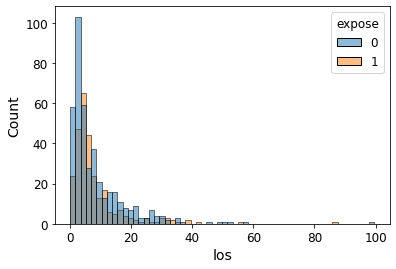

In [84]:
sns.histplot(x = 'los', data=df, hue='expose')
plt.show()

In [85]:
def outlier_check(var, df_name):
    sns.displot(data = df_name, x = var)
    print('Variable: ', var) 
    print('Minimum value: ', df_name[var].min())
    print('10th percentile: ', df_name[var].quantile(0.1))
    print('25th percentile: ', df_name[var].quantile(0.25))
    print('50th percentile: ', df_name[var].quantile(0.5))
    print('90th percentile: ', df_name[var].quantile(0.90))
    print('95th percentile: ', df_name[var].quantile(0.95))
    print('97th percentile: ', df_name[var].quantile(0.97))
    print('98th percentile: ', df_name[var].quantile(0.98))
    print('99th percentile: ', df_name[var].quantile(0.99))
    print('Maximum value: ', df_name[var].max())

Variable:  los
Minimum value:  0.085752
10th percentile:  1.6865375
25th percentile:  2.82296
50th percentile:  5.1342300000000005
90th percentile:  19.41206000000001
95th percentile:  27.375443999999977
97th percentile:  31.206000999999997
98th percentile:  35.047807799999994
99th percentile:  45.17274759999996
Maximum value:  99.63845


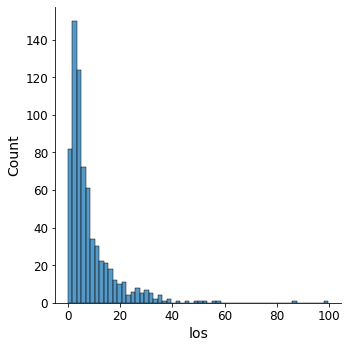

In [86]:
outlier_check('los', df)

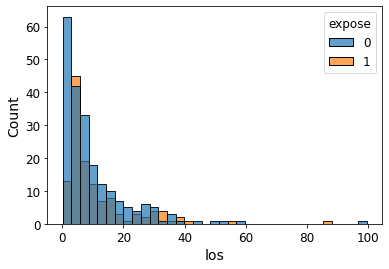

In [87]:
sns.histplot(x ='los', data=df[df['hospital_expire_flag']==0], hue='expose', alpha=0.7)
plt.show()

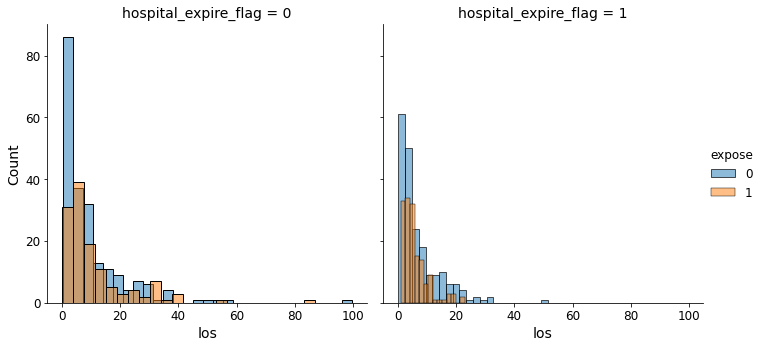

In [88]:
g = sns.FacetGrid(df, col="hospital_expire_flag", hue='expose', height=5)
g.map_dataframe(sns.histplot, x="los", alpha=0.5)
g.add_legend()

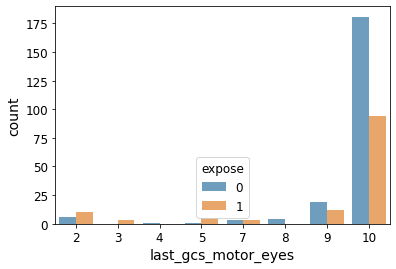

In [89]:
sns.countplot(x ='last_gcs_motor_eyes', data=df[df['hospital_expire_flag']==0], hue='expose', alpha=0.7)
plt.show()

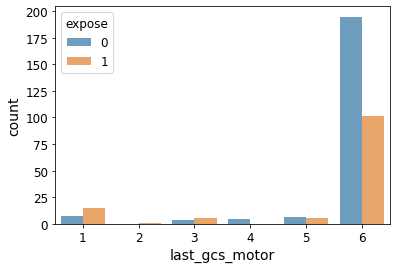

In [90]:
sns.countplot(x ='last_gcs_motor', data=df[df['hospital_expire_flag']==0], hue='expose', alpha=0.7)
plt.show()

#### 8 rows above 45, 2 rows above 60

In [91]:
df[df['los'] > 45]

,subject_id,first_careunit,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,resp_rate_first24h_mean,...,icu_entrydate_weekend,heart_rhythm_first24h_firstRecorded,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis
23,10413295,Surgical Intensive Care Unit (SICU),52.22512,0,0,53.61183,M,86.51515,82.91429,20.51515,...,False,SR (Sinus Rhythm),2.0,10,2.0,10,6,2.0,125,43
43,10699336,Trauma SICU (TSICU),99.63845,0,0,66.01864,M,80.88000,74.76316,22.50000,...,True,SR (Sinus Rhythm),2.0,5,4.0,10,6,10.0,59,37
48,10790860,Medical Intensive Care Unit (MICU),45.13287,0,0,85.52151,M,83.70968,76.15517,17.56667,...,False,SR (Sinus Rhythm),2.0,6,10.0,10,6,10.0,84,34
224,13125051,Cardiac Vascular Intensive Care Unit (CVICU),55.72022,0,1,74.12578,F,73.44444,60.35714,19.75000,...,False,V Paced,2.0,13,2.0,10,6,2.0,75,44
493,16935337,Trauma SICU (TSICU),51.43669,1,0,48.88404,M,77.86207,83.37037,20.77273,...,False,SR (Sinus Rhythm),2.0,3,2.0,2,1,10.0,67,35
589,18295542,Medical Intensive Care Unit (MICU),86.84840,0,1,74.85118,F,93.73077,97.36000,22.32692,...,False,SR (Sinus Rhythm),2.0,7,6.0,10,6,7.0,81,47
628,18969221,Cardiac Vascular Intensive Care Unit (CVICU),58.09610,0,0,66.53535,M,96.05714,91.43243,15.80556,...,False,SR (Sinus Rhythm),4.0,8,2.0,10,6,2.0,111,50
648,19197579,Surgical Intensive Care Unit (SICU),49.12063,0,0,27.25609,M,127.90240,63.68293,31.67442,...,False,ST (Sinus Tachycardia),1.0,1,5.0,10,6,10.0,129,56


In [92]:
df[df['los'] < 1]

,subject_id,first_careunit,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,resp_rate_first24h_mean,...,icu_entrydate_weekend,heart_rhythm_first24h_firstRecorded,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis
74,11172882,Coronary Care Unit (CCU),0.085752,0,1,64.23435,M,50.00000,87.33333,13.66667,...,True,SB (Sinus Bradycardia),1.0,4,3.0,3,1,3.0,22,15
126,11771462,Medical Intensive Care Unit (MICU),0.684618,1,0,95.02472,F,78.88889,72.80000,17.55000,...,False,SR (Sinus Rhythm),2.0,4,3.0,6,4,3.0,63,48
129,11810646,Trauma SICU (TSICU),0.490833,0,1,87.91676,F,66.37500,44.60000,20.38889,...,False,SR (Sinus Rhythm),2.0,5,2.0,2,1,5.0,84,34
155,12173987,Coronary Care Unit (CCU),0.738183,0,0,83.78508,M,68.45455,65.90000,16.04348,...,False,V Paced,2.0,4,5.0,10,6,5.0,42,42
199,12864912,Trauma SICU (TSICU),0.360602,1,0,51.02476,M,71.08333,50.00000,15.69231,...,True,SR (Sinus Rhythm),1.0,2,2.0,2,1,3.0,76,38
257,13655081,Cardiac Vascular Intensive Care Unit (CVICU),0.892928,0,0,69.94043,F,69.76000,78.41667,15.89583,...,False,SR (Sinus Rhythm),1.0,6,2.0,10,6,2.0,18,27
267,13737616,Surgical Intensive Care Unit (SICU),0.291505,1,0,80.67263,M,109.15000,58.40909,22.15000,...,False,NaN,NaN,5,2.0,2,1,2.0,152,67
309,14347918,Cardiac Vascular Intensive Care Unit (CVICU),0.877593,0,0,91.63284,F,72.19048,77.04762,17.71429,...,False,V Paced,2.0,4,2.0,10,6,2.0,77,33
445,16133657,Surgical Intensive Care Unit (SICU),0.513553,0,0,53.91163,F,86.91667,75.81818,14.23077,...,False,SR (Sinus Rhythm),2.0,4,5.0,10,6,5.0,64,41
472,16525967,Surgical Intensive Care Unit (SICU),0.643889,0,0,87.40779,F,67.46667,50.36364,15.40000,...,False,SR (Sinus Rhythm),2.0,5,2.0,4,3,2.0,31,34


#### removing row with los>60 and <1

In [93]:
df = df[(df['los'] <= 60) & (df['los'] >= 1)]

In [94]:
print('After dropping los>60: rows=', df.shape[0], ' cols=', df.shape[1]) 

After dropping los>60: rows= 688  cols= 29


In [95]:
df['los'] = df.loc[:,'los'].round(0)

C:\Users\DarkZ\AppData\Local\Temp\ipykernel_29908\3189507336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['los'] = df.loc[:,'los'].round(0)


In [96]:
df.head()

,subject_id,first_careunit,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,resp_rate_first24h_mean,...,icu_entrydate_weekend,heart_rhythm_first24h_firstRecorded,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis
0,10001884,Medical Intensive Care Unit (MICU),9.0,1,0,77.01830,F,71.39286,86.03846,17.77586,...,False,V Paced,2.0,6,2.0,10,6,2.0,56,34
1,10024982,Coronary Care Unit (CCU),21.0,1,0,85.71412,M,63.11111,84.28000,19.24074,...,False,AF (Atrial Fibrillation),2.0,7,2.0,2,1,2.0,100,45
2,10109956,Medical/Surgical Intensive Care Unit (MICU/SICU),14.0,0,1,62.34224,F,99.12245,86.67000,21.22917,...,True,SR (Sinus Rhythm),2.0,10,2.0,10,6,2.0,86,52
3,10131457,Neuro Surgical Intensive Care Unit (Neuro SICU),11.0,0,0,41.21647,M,54.08333,90.55932,16.84167,...,False,SB (Sinus Bradycardia),2.0,2,2.0,10,6,9.0,31,33
4,10144145,Medical Intensive Care Unit (MICU),15.0,1,0,55.00510,M,68.73077,63.44000,17.34615,...,False,SR (Sinus Rhythm),1.0,5,2.0,9,5,2.0,109,33


# Covariates

In [97]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,688.0,1.495848e+07,2.843481e+06,1.000188e+07,1.256899e+07,1.493701e+07,1.749548e+07,1.992943e+07
los,688.0,8.390988e+00,8.590796e+00,1.000000e+00,3.000000e+00,5.000000e+00,1.100000e+01,5.800000e+01
hospital_expire_flag,688.0,5.159884e-01,5.001079e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
expose,688.0,4.040698e-01,4.910681e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
age,688.0,6.378732e+01,1.703027e+01,2.090920e+01,5.367600e+01,6.499659e+01,7.675726e+01,9.738167e+01
heart_rate_first24h_mean,686.0,8.396310e+01,1.850398e+01,4.296154e+01,7.006613e+01,8.215178e+01,9.597115e+01,1.540290e+02
mbp_first24h_mean,686.0,7.954423e+01,1.107528e+01,4.867500e+01,7.250379e+01,7.824501e+01,8.503645e+01,1.399394e+02
resp_rate_first24h_mean,686.0,2.061971e+01,4.212993e+00,1.025000e+01,1.754134e+01,1.986538e+01,2.323529e+01,3.462500e+01
spo2_first24h_mean,684.0,9.750796e+01,2.675165e+00,7.591667e+01,9.666909e+01,9.814315e+01,9.936167e+01,1.000000e+02
heart_rate_first24h_max,686.0,1.090831e+02,2.506611e+01,5.600000e+01,9.100000e+01,1.065000e+02,1.250000e+02,2.150000e+02


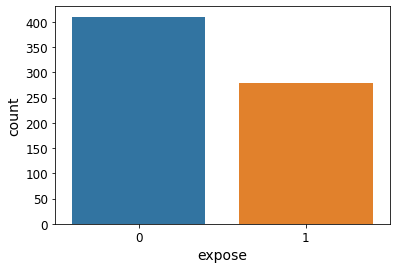

In [98]:
sns.countplot(x = 'expose', data=df)
plt.show()

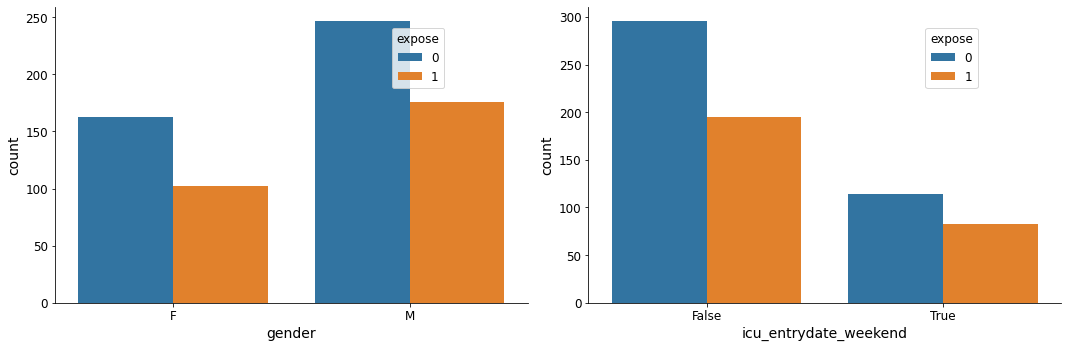

In [99]:
fig = plt.figure(figsize=[15,5])
features = ['gender', 'icu_entrydate_weekend']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(1, 2, i+1)
    ax = sns.countplot(data=df,x=df.columns[loc], hue='expose')
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

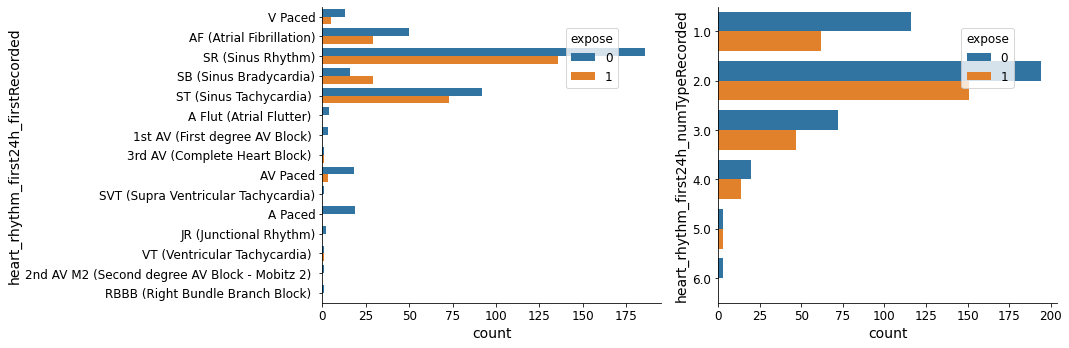

In [100]:
fig = plt.figure(figsize=[15,5])
features = ['heart_rhythm_first24h_firstRecorded',
       'heart_rhythm_first24h_numTypeRecorded']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(1, 2, i+1)
    ax = sns.countplot(data=df,y=df.columns[loc], hue='expose')
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

In [101]:
df.columns

Index(['subject_id', 'first_careunit', 'los', 'hospital_expire_flag', 'expose',
       'age', 'gender', 'heart_rate_first24h_mean', 'mbp_first24h_mean',
       'resp_rate_first24h_mean', 'spo2_first24h_mean',
       'heart_rate_first24h_max', 'mbp_first24h_max', 'resp_rate_first24h_max',
       'spo2_first24h_max', 'heart_rate_first24h_min', 'mbp_first24h_min',
       'resp_rate_first24h_min', 'spo2_first24h_min', 'icu_entrydate_weekend',
       'heart_rhythm_first24h_firstRecorded',
       'heart_rhythm_first24h_numTypeRecorded', 'charlson_comorbidity_index',
       'lowest_gcs_motor_eyes_first24h', 'last_gcs_motor_eyes',
       'last_gcs_motor', 'first_gcs_motor_eyes', 'apsiii', 'oasis'],
      dtype='object')

In [102]:
cont_var = [
    'age',
    'heart_rate_first24h_mean', 'mbp_first24h_mean',
    'resp_rate_first24h_mean','spo2_first24h_mean', 
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h', 'first_gcs_motor_eyes',
    'heart_rate_first24h_max', 'mbp_first24h_max', 'resp_rate_first24h_max',
    'spo2_first24h_max', 'heart_rate_first24h_min', 'mbp_first24h_min',
    'resp_rate_first24h_min', 'spo2_first24h_min', 'oasis', 'apsiii']

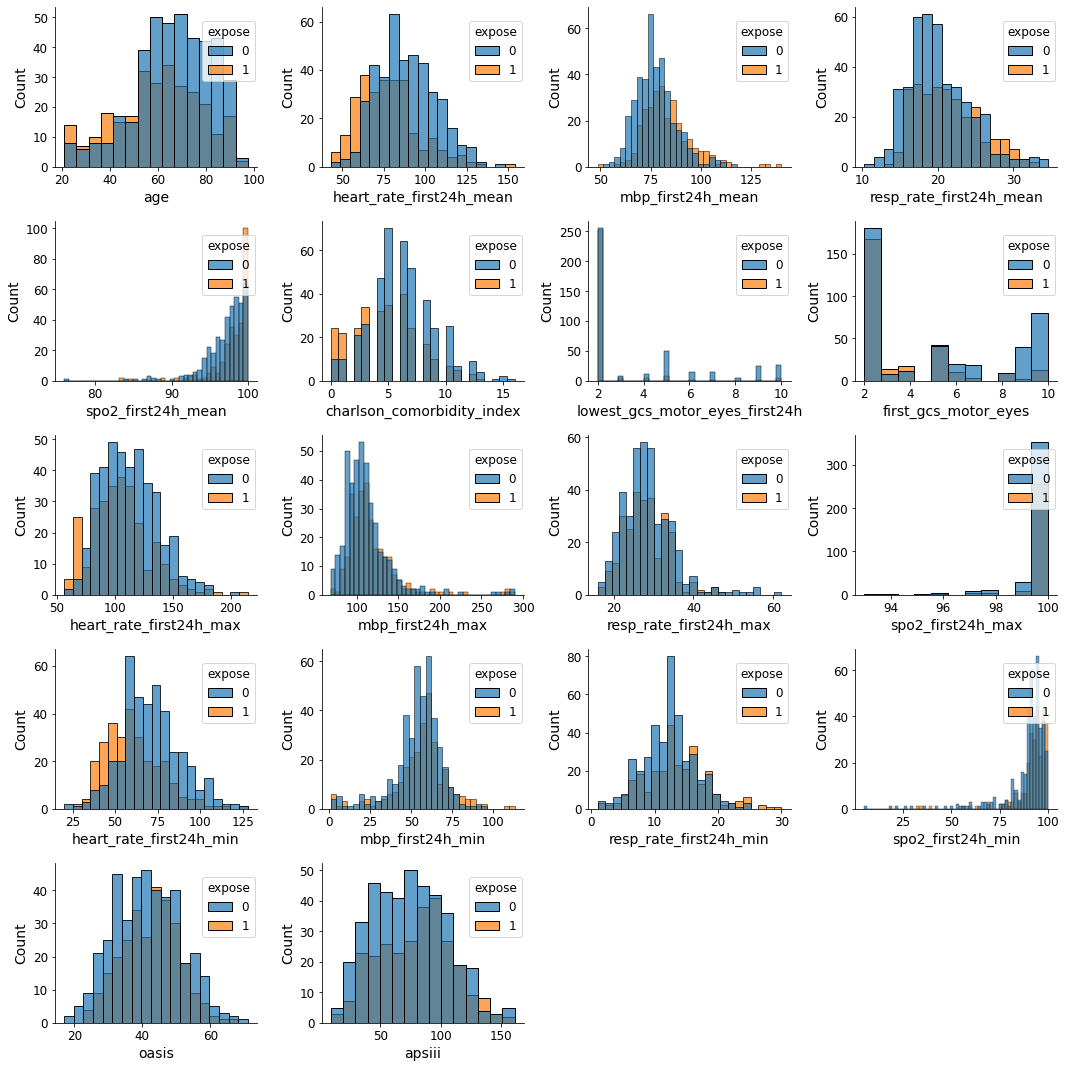

In [103]:
## very slow
fig = plt.figure(figsize=[15,15])
features = cont_var

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(5, 4, i+1)
    ax = sns.histplot(data=df,x=df.columns[loc], hue='expose', alpha=0.7)
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

#### Remove mean spO2 below 90

In [104]:
df[df['spo2_first24h_mean']<90].shape

(15, 29)

In [105]:
df[df['spo2_first24h_mean'].isnull()].shape

(4, 29)

In [106]:
df = df[df['spo2_first24h_mean']>=90]
df.shape

(669, 29)

In [107]:
print('After removing spo2<90: rows=', df.shape[0], ' cols=', df.shape[1]) 

After removing spo2<90: rows= 669  cols= 29


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 0 to 699
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             669 non-null    int64  
 1   first_careunit                         669 non-null    object 
 2   los                                    669 non-null    float64
 3   hospital_expire_flag                   669 non-null    int64  
 4   expose                                 669 non-null    int64  
 5   age                                    669 non-null    float64
 6   gender                                 669 non-null    object 
 7   heart_rate_first24h_mean               669 non-null    float64
 8   mbp_first24h_mean                      669 non-null    float64
 9   resp_rate_first24h_mean                669 non-null    float64
 10  spo2_first24h_mean                     669 non-null    float64
 11  heart_

### Drop rows with missing values

In [109]:
df.dropna(inplace=True)
print('After dropping rows with missing vals: rows=', df.shape[0], ' cols=', df.shape[1])

After dropping rows with missing vals: rows= 668  cols= 29


In [110]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,668.0,1.496595e+07,2.835497e+06,1.000188e+07,1.259225e+07,1.495048e+07,1.748581e+07,1.992943e+07
los,668.0,8.365269e+00,8.561347e+00,1.000000e+00,3.000000e+00,5.000000e+00,1.000000e+01,5.800000e+01
hospital_expire_flag,668.0,5.134731e-01,5.001930e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
expose,668.0,4.056886e-01,4.913928e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
age,668.0,6.394693e+01,1.708835e+01,2.090920e+01,5.376907e+01,6.534605e+01,7.695700e+01,9.738167e+01
heart_rate_first24h_mean,668.0,8.359791e+01,1.823405e+01,4.296154e+01,6.991322e+01,8.202000e+01,9.569371e+01,1.434583e+02
mbp_first24h_mean,668.0,7.964693e+01,1.113167e+01,4.867500e+01,7.254583e+01,7.824501e+01,8.518731e+01,1.399394e+02
resp_rate_first24h_mean,668.0,2.055401e+01,4.177611e+00,1.203704e+01,1.751562e+01,1.982108e+01,2.312211e+01,3.462500e+01
spo2_first24h_mean,668.0,9.777104e+01,1.984110e+00,9.035897e+01,9.680404e+01,9.823303e+01,9.937740e+01,1.000000e+02
heart_rate_first24h_max,668.0,1.086422e+02,2.459518e+01,5.600000e+01,9.100000e+01,1.060000e+02,1.240000e+02,2.000000e+02


### Categorizing heart rhythm


In [111]:
df['heart_rhythm_first24h_firstRecorded'].value_counts()

SR (Sinus Rhythm)                                 314
ST (Sinus Tachycardia)                            160
AF (Atrial Fibrillation)                           76
SB (Sinus Bradycardia)                             45
AV Paced                                           21
A Paced                                            19
V Paced                                            18
A Flut (Atrial Flutter)                             4
1st AV (First degree AV Block)                      2
3rd AV (Complete Heart Block)                       2
JR (Junctional Rhythm)                              2
VT (Ventricular Tachycardia)                        2
SVT (Supra Ventricular Tachycardia)                 1
2nd AV M2 (Second degree AV Block - Mobitz 2)       1
RBBB (Right Bundle Branch Block)                    1
Name: heart_rhythm_first24h_firstRecorded, dtype: int64

In [112]:
list1 = ['SB (Sinus Bradycardia)','V Paced',
       'A Flut (Atrial Flutter) ', '1st AV (First degree AV Block) ',
       '3rd AV (Complete Heart Block) ', 'AV Paced',
       'SVT (Supra Ventricular Tachycardia)', 'A Paced',
       'JR (Junctional Rhythm)', 'VT (Ventricular Tachycardia) ',
       '2nd AV M2 (Second degree AV Block - Mobitz 2) ',
       'RBBB (Right Bundle Branch Block) ']

df['heart_rhythm_cat'] = np.where(df['heart_rhythm_first24h_firstRecorded'].isin(list1),'rare rhythm', df['heart_rhythm_first24h_firstRecorded'])

In [113]:
df['heart_rhythm_cat'].value_counts()

SR (Sinus Rhythm)           314
ST (Sinus Tachycardia)      160
rare rhythm                 118
AF (Atrial Fibrillation)     76
Name: heart_rhythm_cat, dtype: int64

In [114]:
#plt.figure(figsize=(15,15))
#sns.boxplot(data=df[cont_var], orient="h", palette="Set2")

In [115]:
# df = df[df['first_careunit'] != 'Cardiac Vascular Intensive Care Unit (CVICU)']
print('After dropping rows with missing vals: rows=', df.shape[0], ' cols=', df.shape[1])

After dropping rows with missing vals: rows= 668  cols= 30


In [116]:
df.drop('first_careunit', axis=1, inplace=True)

### drop lowest GCS >= 6

In [119]:
df = df[df['lowest_gcs_motor_eyes_first24h'] < 6]

# Summary Data Cleaning
- remove unused columns
- remove columns with highly correlated data (repeated info eg. max vs mean HR)
- remove rows with missing values
- remove los >60
- remove spO2 mean <90
- remove columns with large missing values

# EDA Cleaned Data

In [120]:
print('After cleaning Final: rows=', df.shape[0], ' cols=', df.shape[1])

After cleaning Final: rows= 577  cols= 29


In [121]:
# distribution of control vs treatment
df['expose'].value_counts()

0    314
1    263
Name: expose, dtype: int64

In [122]:
# mortality distribution
df['hospital_expire_flag'].value_counts()

1    292
0    285
Name: hospital_expire_flag, dtype: int64

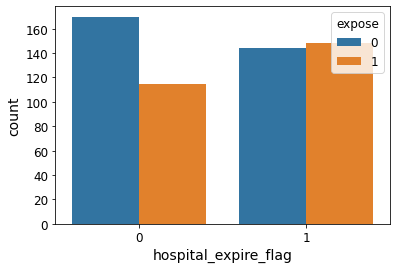

In [123]:
sns.countplot(x = 'hospital_expire_flag', data=df, hue='expose')
plt.show()

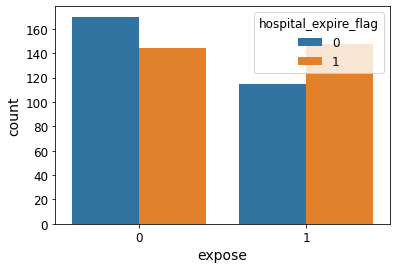

In [124]:
sns.countplot(x = 'expose', data=df, hue='hospital_expire_flag')
plt.show()

<AxesSubplot:xlabel='los', ylabel='Count'>

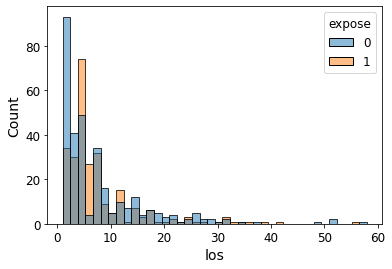

In [125]:
sns.histplot(x ='los', data=df, hue='expose')

Text(0.5, 1.0, 'Natural log transformation of los')

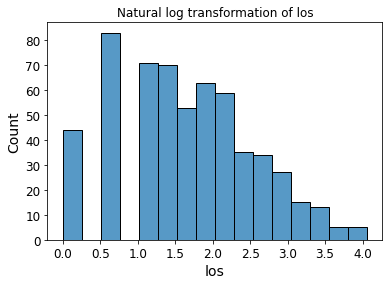

In [126]:
log_los = np.log(df['los'])
sns.histplot(data=log_los)
plt.title('Natural log transformation of los')

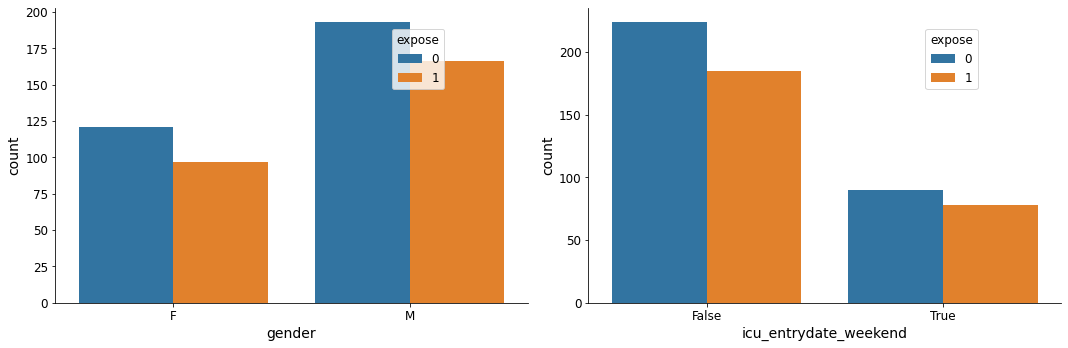

In [127]:
fig = plt.figure(figsize=[15,5])
features = ['gender', 'icu_entrydate_weekend']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(1, 2, i+1)
    ax = sns.countplot(data=df,x=df.columns[loc], hue='expose')
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

#### heart rhythm

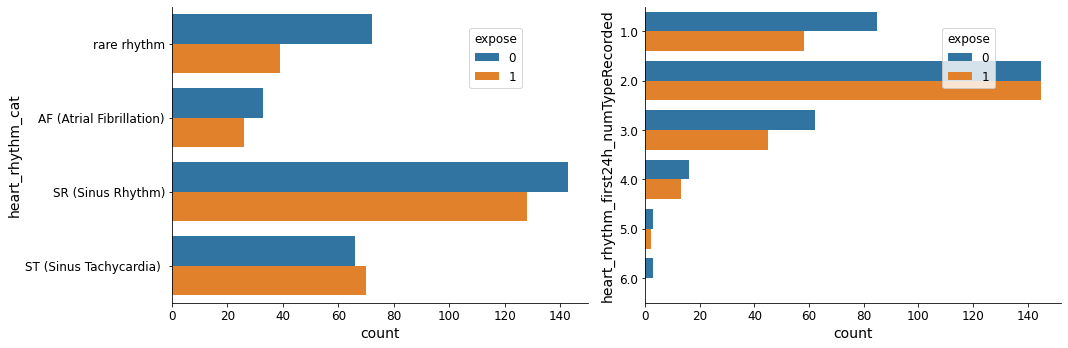

In [128]:
fig = plt.figure(figsize=[15,5])
features = ['heart_rhythm_cat',
       'heart_rhythm_first24h_numTypeRecorded']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(1, 2, i+1)
    ax = sns.countplot(data=df,y=df.columns[loc], hue='expose')
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

Shockable probably not a meaningful feature, too little in shockable group

#### continuous variables

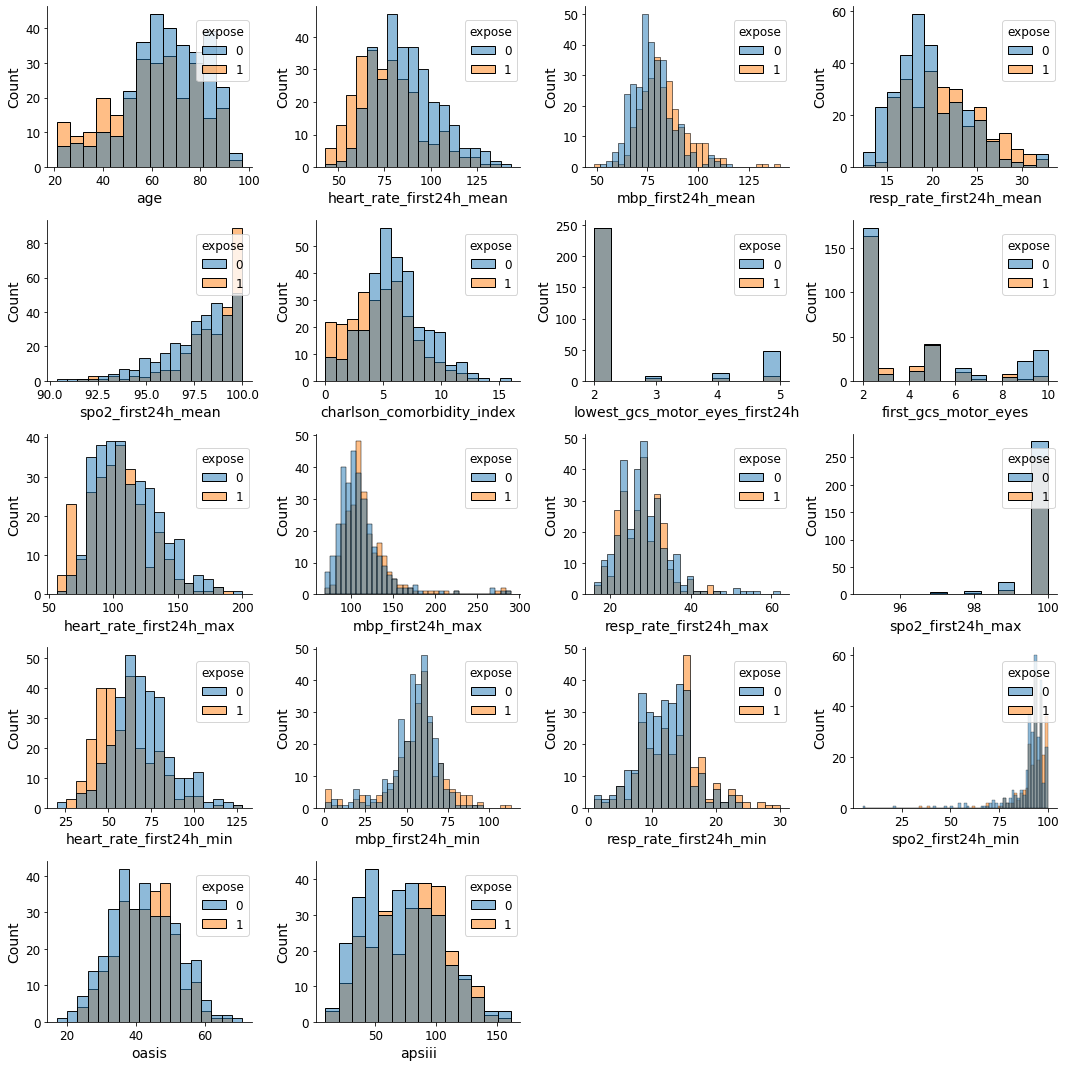

In [129]:
fig = plt.figure(figsize=[15,15])
features = cont_var

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(5, 4, i+1)
    ax = sns.histplot(data=df,x=df.columns[loc], hue='expose')
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

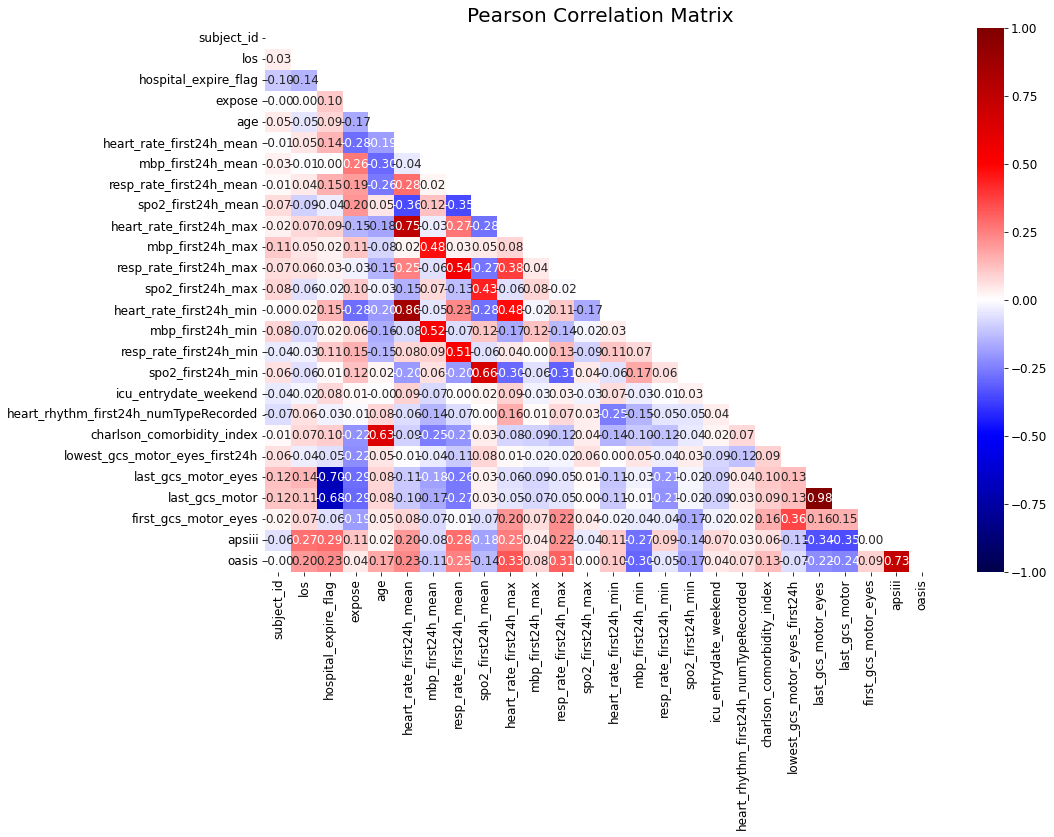

In [130]:
plt.figure(figsize=(15,10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(data= corr_matrix, mask = mask, cmap='seismic', vmax = 1, vmin=-1, annot=True, fmt='0.2f')
plt.title('Pearson Correlation Matrix', fontsize = 20)
plt.show()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 0 to 699
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             577 non-null    int64  
 1   los                                    577 non-null    float64
 2   hospital_expire_flag                   577 non-null    int64  
 3   expose                                 577 non-null    int64  
 4   age                                    577 non-null    float64
 5   gender                                 577 non-null    object 
 6   heart_rate_first24h_mean               577 non-null    float64
 7   mbp_first24h_mean                      577 non-null    float64
 8   resp_rate_first24h_mean                577 non-null    float64
 9   spo2_first24h_mean                     577 non-null    float64
 10  heart_rate_first24h_max                577 non-null    float64
 11  mbp_fi

In [133]:
df.to_csv('data\df_clean_0424_CVICU.csv', index=False)

In [68]:
#df= pd.read_csv('df_clean.csv')